In [1]:
import re
import os
import time
import pickle
import IPython
import sklearn
import numpy as np
import kmapper as km
import pandas as pd
import seaborn as sns
from umap import UMAP

from tqdm import tqdm
from collections import defaultdict
from sklearn.manifold import t_sne, isomap

from sklearn import datasets
from sklearn.cluster import DBSCAN

from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


import cx_Oracle

# oracle
oracle_user = "ro_user"
oracle_pass = "ro_user"
oracle_scheme = "aml_evraz"
oracle_host = "192.168.101.13/rnd"
oracle_connection = cx_Oracle.connect(oracle_user, oracle_pass, oracle_host, encoding = "UTF-8", nencoding = "UTF-8")
oracle_cursor = oracle_connection.cursor()


%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

In [2]:
class Timer:
    def __init__(self, msg='operation', verbose=True):
        self.msg = msg
        self.verbose = verbose       
    def __enter__(self, ):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start
        if self.verbose:
            print('{} took {:.3f}s'.format(self.msg, self.interval), flush=True)


def df_categorical_variables_stat(df, max_cardinality=200):
    for colname in df.columns:
        print('next_column: {}'.format(colname))
        uniq_vals = df[colname].unique()
        nunique = len(uniq_vals)
        print("# of uniqs: {}".format(nunique))
        if nunique < max_cardinality:
            print('Viable Categorical. Value counts:')
            print(df[colname].value_counts(dropna=False))
        else:
            print('High cardinality/Non categorical')
        print((('-' * 80) + '\n')*3)

In [3]:
try:
    del susp_ops
except:
    pass

try:
    del susp_members
except:
    pass


try:
    del off_ops
except:
    pass

try:
    del off_members
except:
    pass

In [4]:
with Timer('read susp_ops', True):
    susp_ops = pd.read_csv('../../data/susp_ops.csv')

read susp_ops took 3.644s


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4,9,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
with Timer('read susp_members', True):
    susp_members = pd.read_csv('../../data/susp_members.csv')
with Timer('read off_ops', True):
    off_ops = pd.read_csv('../../data/off_ops.csv')
with Timer('read off_ops', True):
    off_members = pd.read_csv('../../data/off_members.csv')

read susp_members took 4.064s


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,3,21,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,3,8,9,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


read off_ops took 46.899s


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,3,5,11,17,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


read off_ops took 43.044s


In [6]:
with Timer('process off_ops', True):
    off_ops.loc[:, 'P_OPERATIONDATETIME'] = pd.to_datetime(off_ops['P_OPERATIONDATETIME'])
    off_ops.sort_values(by='P_OPERATIONDATETIME', kind='mergesort', inplace=True)

process off_ops took 4.886s


### Helper functions

* process_client_indices() --- parse numeric indices with small typo errors to ints, and encode non-digit ids with negative numbers
* flatten_by_column() --- each operation_id in OFF_OPERATIONS has 1-3 linked members with disjoint P_CLIENTROLE values. We want unique operation_id per row, with linked members with diferent roles spreading into a row columns.
* join_ops_with_flatten_members() --- join operations dataframe with flattened operation id dataframe

In [11]:
def process_client_indices(client_indices, trivial_to_nontrivial=None):
    if trivial_to_nontrivial is None:
        trivial_ids_to_nontrivial = defaultdict(lambda: -len(trivial_ids_to_nontrivial) - 2)

    nontrivial_clients_ids = client_indices.copy()
    nontrivial_clients_ids[nontrivial_clients_ids.isnull()] = -1

    nontrivial_clients_ids = nontrivial_clients_ids.map(str)

    nontrivial_ids = nontrivial_clients_ids.map(lambda s: s.strip())

    is_trivial = nontrivial_ids.map(lambda s: len(re.findall('^([\d]+|-[\d]+)', s)) == 0)
    trivial_ids = nontrivial_ids[is_trivial]

    for ti in trivial_ids:
        trivial_ids_to_nontrivial[ti]
    trivial_ids_to_nontrivial
    nontrivial_ids[is_trivial] = trivial_ids.map(lambda s: str(trivial_ids_to_nontrivial[s]))

    nontrivial_ids = nontrivial_ids.map(lambda s: re.findall('^([\d]+|-[\d]+)', s)[0]).map(int)
    return nontrivial_ids, trivial_to_nontrivial


def flatten_by_column(df, to_flatten, flatten_by, group_by, names_flatten_by=None):
    if names_flatten_by is None:
        names_flatten_by = {
            uniq_val: '{}={}'.format(flatten_by, uniq_val)
            for uniq_val in df[flatten_by].unique()
        }
    #column_to_flatten_by = 'P_CLIENTROLE'
    #column_to_group_by = 'P_SUSPICIOUSOPERATIONID'
    #column_to_flatten = 'P_CLIENTID'
    column_to_flatten_by = flatten_by
    column_to_flatten = to_flatten
    column_to_group_by = group_by
    frames_to_join = [
        df[[column_to_group_by, column_to_flatten]][df[column_to_flatten_by] == uniq_val]
        for uniq_val in df[column_to_flatten_by].unique()
    ]

    for frame, uniq_val in zip(frames_to_join, df[flatten_by].unique()):
        frame.rename(columns={column_to_flatten: names_flatten_by[uniq_val]}, inplace=True)
        frame.set_index(column_to_group_by, inplace=True)

    res = frames_to_join[0].join(frames_to_join[1:], how='outer')
    return res


def join_ops_with_flatten_members(ops, flatten_ops_with_members, id_colname='ID'):
    ops_to_join = ops.set_index(id_colname, drop=False)
    joined_ops = ops_to_join.join(flatten_ops_with_members, how='left')
    joined_ops.reset_index(drop=True, inplace=True)
    return joined_ops

### Parse P_CLIENTID for offline members

In [12]:
with Timer('off_members client_ids processing', True):
    off_members.loc[:, 'P_CLIENTID'], trivial_ids_to_nontrivial = process_client_indices(off_members.P_CLIENTID)

off_members client_ids processing took 46.873s


### P_CLIENTROLE has only 3 values and not more than 3 P_CLIENTID with different P_CLIENTROLE corresponds to a single P_OPERATIONID value. So flatten them by P_CLIENTROLE

In [13]:
try:
    del off_res
except:
    pass

names_by_clientrole = {
    1: 'id_from',
    2: 'id_to',
    3: 'id_susp_3',
    4: 'id_susp_4',
    5: 'id_beneficial',
    6: 'id_susp_6'
}

with Timer('flatten grouped P_OPERATIONID with P_CLIENTID by P_CLIENTROLE', True):
    off_res = flatten_by_column(off_members, 'P_CLIENTID', 'P_CLIENTROLE', 'P_OPERATIONID', names_by_clientrole)

off_res = off_res.reset_index().drop_duplicates().set_index('P_OPERATIONID', drop=True)
try:
    del joined_offline_ops
except:
    pass

with Timer('join offline operations with flattened members info', True):
    joined_offline_ops = join_ops_with_flatten_members(off_ops, off_res)

flatten grouped P_OPERATIONID with P_CLIENTID by P_CLIENTROLE took 20.413s
join offline operations with flattened members info took 6.870s


### Make 0-based indices for every operation and client we met

In [52]:
try:
    del operationid_counter
except:
    pass

try:
    del operationid_inv_counter
except:
    pass

with Timer('building operation_id counter', True):
    if os.path.exists('operationid_counter.pickle'):
        with open('operationid_counter.pickle', 'rb') as handle:
            operationid_counter = defaultdict(lambda: len(operationid_counter), pickle.load(handle))
    else:
        operationid_counter = defaultdict(lambda: len(operationid_counter))
        with open('operationid_counter.pickle', 'wb') as handle:
            pickle.dump(dict(operationid_counter), handle, protocol=pickle.HIGHEST_PROTOCOL)
    joined_offline_ops.loc[:, 'ID'] = joined_offline_ops['ID'].map(operationid_counter.__getitem__)
    operationid_inv_counter = {v: k for k, v in operationid_counter.items()}

building operation_id counter took 3.740s


In [46]:
try:
    del clientid_counter
except:
    pass

try:
    del clientid_inv_counter
except:
    pass

with Timer('building client_id counter', True):
    if os.path.exists('clientid_counter.pickle'):
        with open('clientid_counter.pickle', 'rb') as handle:
            clientid_counter = defaultdict(lambda: len(clientid_counter), pickle.load(handle))
    else:
        clientid_counter = defaultdict(lambda: len(clientid_counter))
        for row_num, row in tqdm(joined_offline_ops[['ID', 'id_from', 'id_to', 'id_beneficial']].iterrows()):
            for client_id in [row.id_from, row.id_to, row.id_beneficial]:
                if np.isfinite(client_id):
                    clientid_counter[client_id]
        with open('clientid_counter.pickle', 'wb') as handle:
            pickle.dump(dict(clientid_counter), handle, protocol=pickle.HIGHEST_PROTOCOL)
    clientid_inv_counter = {v: k for k, v in clientid_counter.items()}

building client_id counter took 2.552s


### set 'target' column with susp_ops P_SENDTOKFMBOOL values. Normal transactions will have value -1
### also set labels indicationg transaction being predecessorof fraud, using P_OPERATIONLIST

In [31]:
susp_ops = susp_ops[~susp_ops.P_OFFLINEOPERATIONID.isnull()].copy()
susp_ops.loc[susp_ops.P_OPERATION_LIST.isnull(), 'P_OPERATION_LIST'] = ''

In [218]:
#joined_offline_ops.loc[:, 'P_OPERATIONDATETIME'] = pd.to_datetime(joined_offline_ops.P_OPERATIONDATETIME)
joined_offline_ops.set_index('ID', drop=False, inplace=True)

In [60]:
try:
    del patterns
except:
    pass

try:
    del pat_starts
except:
    pass

try:
    del pat_ends
except:
    pass

try:
    del pat_concat
except:
    pass

with Timer('retrieve and remap susp op_id indices chains'):
    patterns = [
        np.array([operationid_counter[int(el)] for el in re.findall('\d+', s) if int(el) in operationid_counter], dtype=int)
        for s in tqdm(susp_ops.P_OPERATION_LIST)
    ]
    pat_concat = np.concatenate(patterns)
    pat_ends = np.cumsum([len(pat) for pat in patterns])
    pat_starts = np.concatenate([[0], pat_ends[:-1]])

100%|██████████| 401500/401500 [00:03<00:00, 132962.65it/s]


retrieve and remap susp op_id indices chains took 3.196s


In [61]:
try:
    del dats
except:
    pass

try:
    del dats_reset
except:
    pass

with Timer('retrieve susp op chains dates'):
    dats = joined_offline_ops.P_OPERATIONDATETIME[pat_concat]
    dats_reset = dats.reset_index(drop=True)

retrieve susp op chains dates took 6.716s


In [131]:
try:
    del uniqs
except:
    pass

try:
    del time_to_fraud
except:
    pass

try:
    del links_to_fraud
except:
    pass

try:
    del susp_ops_raw_ids
except:
    pass

try:
    del reference_times
except:
    pass

try:
    del reference_times_aligned
except:
    pass

with Timer('initialize structs for counting steps to fraud'):
    uniqs = {}
    links_to_fraud = {}
    time_to_fraud = {}
    susp_ops_raw_ids = susp_ops.P_OFFLINEOPERATIONID.map(operationid_counter.get).values
    reference_times = joined_offline_ops.P_OPERATIONDATETIME[susp_ops_raw_ids]
    reference_times_aligned = reference_times.repeat(pat_ends - pat_starts)
    raw_refs = reference_times_aligned.values
    raw_dats = dats_reset.values

initialize structs for counting steps to fraud took 5.130s


In [132]:
with Timer('fill steps to fraud maps'):
    for idx, pat_start, pat_end in tqdm(list(zip(susp_ops_raw_ids, pat_starts, pat_ends))):
        patts = pat_concat[pat_start:pat_end]
        times = dats_reset[pat_start:pat_end]
        deltas = raw_refs[pat_start:pat_end] - raw_dats[pat_start:pat_end]
        uniqs[idx] = 0
        time_to_fraud[idx] = np.timedelta64(0)
        links_to_fraud[idx] = idx
        places = np.arange(len(patts), 0, -1)
        #reference_time = reference_times[idx]
        #times_to_fraud = reference_time - times
        #print(times_to_fraud)
        #print(times.argsort().values)
        #print(times_to_fraud[times.argsort().index])
        for pat, dt_fraud, place in zip(patts[times.argsort().values], deltas[times.argsort().values], places):
            if pat in uniqs and uniqs[pat] <= place:
                continue
            uniqs[pat] = place
            links_to_fraud[pat] = idx
            time_to_fraud[pat] = dt_fraud

100%|██████████| 401500/401500 [02:21<00:00, 2834.93it/s]

fill steps to fraud maps took 146.027s


In [128]:
joined_offline_ops.columns

Index(['ID', 'P_ISSUEDBID', 'P_BANKOPERATIONID', 'P_BRANCH', 'P_CURRENCYCODE',
       'P_OPERATIONDATETIME', 'P_BASEAMOUNT', 'P_CURRENCYAMOUNT', 'P_EKNPCODE',
       'P_DOCNUMBER', 'P_DOCDATE', 'P_DOCCATEGORY', 'P_OPERATIONREASON',
       'P_TOEXTRACTBOOL', 'P_DATE_INSERT', 'CHANGEDATE', 'P_KFM_OPER_REASON',
       'P_BS_OPER_TYPE', 'P_ORIG_OPER_NUMBER', 'P_WAS_SEND', 'P_OPERATIONDATE',
       'id_from', 'id_to', 'id_beneficial'],
      dtype='object')

In [129]:
joined_offline_ops['raw_id_from'] = joined_offline_ops.id_from.map(clientid_counter.get)
joined_offline_ops['raw_id_to'] = joined_offline_ops.id_to.map(clientid_counter.get)
joined_offline_ops['raw_id_beneficial'] = joined_offline_ops.id_beneficial.map(clientid_counter.get)

In [181]:
joined_offline_ops['steps_to_fraud'] = joined_offline_ops.ID.map(uniqs.get)
joined_offline_ops['links_to_fraud'] = joined_offline_ops.ID.map(links_to_fraud.get)
joined_offline_ops['time_to_fraud'] = joined_offline_ops.ID.map(time_to_fraud.get)

In [172]:
with Timer('setting proper labels for learning'):
    target_mapped = defaultdict(lambda: -1)

    for i, row in tqdm(susp_ops[['P_OFFLINEOPERATIONID', 'P_SENDTOKFMBOOL']].iterrows()):
        off_op_id, to_kfm = operationid_counter[int(row.P_OFFLINEOPERATIONID)], row.P_SENDTOKFMBOOL
        if off_op_id not in target_mapped:
            target_mapped[off_op_id] = 0 if to_kfm == 2 else 1
        else:
            cur_target = target_mapped[off_op_id]
            if cur_target == 0 and to_kfm != 2:
                target_mapped[off_op_id] = 1

401500it [00:20, 19420.49it/s]

setting proper labels for learning took 20.840s


In [182]:
joined_offline_ops['target'] = joined_offline_ops.ID.map(target_mapped.__getitem__)

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


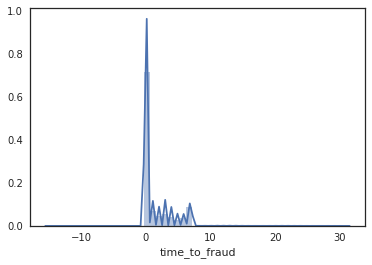

In [192]:
sns.distplot(joined_offline_ops.time_to_fraud[~joined_offline_ops.time_to_fraud.isnull()].dt.days)

In [195]:
joined_offline_ops['target_linked'] = joined_offline_ops.links_to_fraud.map(target_mapped.get)

In [198]:
ktp = joined_offline_ops.time_to_fraud[joined_offline_ops['target_linked'] == 1]
kfp = joined_offline_ops.time_to_fraud[joined_offline_ops['target_linked'] == 0]
knorm = joined_offline_ops.time_to_fraud[joined_offline_ops['target_linked'] == -1]

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


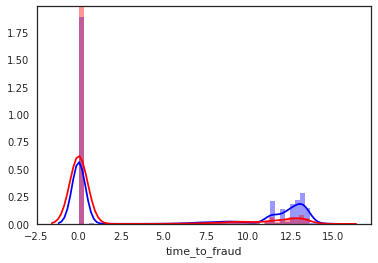

In [217]:
for col, color in zip([kfp, ktp], ['b', 'r']):
    sns.distplot(np.log1p(np.clip(col[~col.isnull()].dt.total_seconds(), a_min=0, a_max=1e18)), color=color)

In [218]:
joined_offline_ops.columns

Index(['ID', 'P_ISSUEDBID', 'P_BANKOPERATIONID', 'P_BRANCH', 'P_CURRENCYCODE',
       'P_OPERATIONDATETIME', 'P_BASEAMOUNT', 'P_CURRENCYAMOUNT', 'P_EKNPCODE',
       'P_DOCNUMBER', 'P_DOCDATE', 'P_DOCCATEGORY', 'P_OPERATIONREASON',
       'P_TOEXTRACTBOOL', 'P_DATE_INSERT', 'CHANGEDATE', 'P_KFM_OPER_REASON',
       'P_BS_OPER_TYPE', 'P_ORIG_OPER_NUMBER', 'P_WAS_SEND', 'P_OPERATIONDATE',
       'id_from', 'id_to', 'id_beneficial', 'raw_id_from', 'raw_id_to',
       'raw_id_beneficial', 'steps_to_fraud', 'links_to_fraud',
       'time_to_fraud', 'target', 'target_linked'],
      dtype='object')

In [ ]:
is_trans = ~joined_offline_ops.raw_id_from.isnull() & ~joined_offline_ops.raw_id_to.isnull()

In [256]:
joined_trans = joined_offline_ops[is_trans]

In [257]:
joined_trans.columns

Index(['ID', 'P_ISSUEDBID', 'P_BANKOPERATIONID', 'P_BRANCH', 'P_CURRENCYCODE',
       'P_OPERATIONDATETIME', 'P_BASEAMOUNT', 'P_CURRENCYAMOUNT', 'P_EKNPCODE',
       'P_DOCNUMBER', 'P_DOCDATE', 'P_DOCCATEGORY', 'P_OPERATIONREASON',
       'P_TOEXTRACTBOOL', 'P_DATE_INSERT', 'CHANGEDATE', 'P_KFM_OPER_REASON',
       'P_BS_OPER_TYPE', 'P_ORIG_OPER_NUMBER', 'P_WAS_SEND', 'P_OPERATIONDATE',
       'id_from', 'id_to', 'id_beneficial', 'raw_id_from', 'raw_id_to',
       'raw_id_beneficial', 'steps_to_fraud', 'links_to_fraud',
       'time_to_fraud', 'target', 'target_linked'],
      dtype='object')

In [259]:
df_categorical_variables_stat(joined_trans)

next_column: ID
# of uniqs: 3275293
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_ISSUEDBID
# of uniqs: 5
Viable Categorical. Value counts:
3    2213366
5     658977
1     326621
4      53632
2      22697
Name: P_ISSUEDBID, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_BANKOPERATIONID
# of uniqs: 3275293
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
---------------------------

# of uniqs: 91
Viable Categorical. Value counts:
2017-03-24 00:00:00    108264
2017-01-04 00:00:00     84823
2017-02-13 00:00:00     82027
2017-01-09 00:00:00     77827
2017-03-06 00:00:00     77399
2017-01-30 00:00:00     76719
2017-02-06 00:00:00     76670
2017-01-23 00:00:00     76579
2017-03-13 00:00:00     76278
2017-02-27 00:00:00     75459
2017-01-16 00:00:00     75031
2017-03-27 00:00:00     72451
2017-02-20 00:00:00     69378
2017-03-09 00:00:00     60490
2017-02-28 00:00:00     56149
2017-02-10 00:00:00     55204
2017-01-10 00:00:00     54684
2017-01-31 00:00:00     54515
2017-02-01 00:00:00     53573
2017-01-24 00:00:00     53432
2017-01-13 00:00:00     53027
2017-03-07 00:00:00     52352
2017-01-06 00:00:00     51893
2017-01-20 00:00:00     51567
2017-03-31 00:00:00     51248
2017-03-01 00:00:00     51101
2017-02-03 00:00:00     50969
2017-02-08 00:00:00     50955
2017-03-15 00:00:00     50568
2017-02-07 00:00:00     50522
                        ...  
2017-03-04 00:00:00  

In [262]:
selected_flow_columns = [
    'ID',
    'P_OPERATIONDATETIME',
    'raw_id_from',
    'raw_id_to',
    'target'
]

selected_scoring_columns = [
    'ID',
    'P_ISSUEDBID',
    'P_BRANCH',
    'P_CURRENCYCODE',
    'P_EKNPCODE',
    'P_DOCCATEGORY',
    'P_KFM_OPER_REASON',
    'P_BS_OPER_TYPE',
    'P_WAS_SEND',
    'target'
]

In [263]:
trans_flow = joined_trans[selected_flow_columns].copy()

In [277]:
peke = joined_trans[joined_trans.id_to == int(joined_trans.id_to[0])].P_OPERATIONREASON

In [ ]:
len(peke.unique())

KeyboardInterrupt: 

In [165]:
keke = susp_ops[susp_ops.P_OFFLINEOPERATIONID == 568608197.0]

In [168]:
interesting_columns = [
    'ID',
    'P_OPERATIONDATETIME',
    'P_MESS_NUMBER',
    'P_MESS_DATE',
    'P_SUSPIC_KIND',
    'P_SUSPICIOUSTYPECODE', 'P_CRITERIAFIRST', 'P_OFFLINEOPERATIONID', 'P_SENDTOKFMBOOL', 'P_DATE_UPDATE']
for cname in interesting_columns:
    print(keke[cname])
    print('-'*80)

396480    569036971
401170    568762962
Name: ID, dtype: int64
--------------------------------------------------------------------------------
396480    2017-03-31 13:53:40
401170    2017-03-31 13:53:40
Name: P_OPERATIONDATETIME, dtype: object
--------------------------------------------------------------------------------
396480      -1
401170    6276
Name: P_MESS_NUMBER, dtype: int64
--------------------------------------------------------------------------------
396480    2017-04-03 07:14:42
401170    2017-04-03 10:51:27
Name: P_MESS_DATE, dtype: object
--------------------------------------------------------------------------------
396480    4
401170    1
Name: P_SUSPIC_KIND, dtype: int64
--------------------------------------------------------------------------------
396480     511.0
401170    1111.0
Name: P_SUSPICIOUSTYPECODE, dtype: float64
--------------------------------------------------------------------------------
396480    4003.0
401170       NaN
Name: P_CRITERIAFIRST, d

In [144]:
len(target_mapped.P_OFFLINEOPERATIONID.unique()), len(target_mapped)

(398518, 401500)

In [ ]:
target_mapped[target_mapped != 2] = 1
target_mapped[target_mapped == 2] = 0

In [142]:
target_mapped.set_index(susp_ops.P_OFFLINEOPERATIONID.map(operationid_counter.get))

AttributeError: 'Series' object has no attribute 'set_index'

In [241]:
joined_offline_ops['target'] = -1
joined_offline_ops[joined_offline_ops.isin(susp_ops.P_OFFLINEOPERATIONID.map(operationid_counter.get)), 'target'] = susp_ops.P_OFFLINEOPERATIONID

In [134]:
susp_ops.P_OFFLINEOPERATIONID.map(operationid_counter.get)

0          114831
1          114664
2          114857
3          114773
4          125487
5          154441
6          153277
7          153022
8          137018
9          136915
10         136784
11         136752
12         210774
13         210771
14         210766
15         210754
16         198422
17         198406
18         198375
19         198336
20         181752
21         181749
22         181278
23         139999
24         139934
25         138951
26         139012
27         214867
28         214865
29         214864
           ...   
401527    8222131
401528    8222130
401529    8222115
401530    8222114
401531    8222142
401532    8222176
401533    8222159
401534    8222171
401535    8222170
401536    8222153
401537    8222125
401538    8222124
401539    8222109
401540    8222108
401541    8222093
401542    8222152
401543    8222135
401544    8222134
401545    8222165
401546    8222164
401547    8222105
401548    8222104
401549    8222089
401550    8222088
401551    

In [130]:
time_to_fraud

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 6291457: numpy.timedelta64(0,'ns'),
 5941932: numpy.timedelta64(259200000000000,'ns'),
 2097162: numpy.timedelta64(172800000000000,'ns'),
 6291467: 0,
 4194316: numpy.timedelta64(0,'ns'),
 6291458: numpy.timedelta64(345600000000000,'ns'),
 6990509: 0,
 6291472: numpy.timedelta64(0,'ns'),
 19: numpy.timedelta64(448800000000000,'ns'),
 2097175: 0,
 6291482: 0,
 6291484: numpy.timedelta64(345600000000000,'ns'),
 6291487: numpy.timedelta64(604800000000000,'ns'),
 6291488: 0,
 4194343: numpy.timedelta64(518400000000000,'ns'),
 6291496: 0,
 2097193: numpy.timedelta64(432000000000000,'ns'),
 2097194: numpy.timedelta64(172800000000000,'ns'),
 2097197: numpy.timedelta64(604800000000000,'ns'),
 7946867: numpy.timedelta64(86400000000000,'ns'),
 699059: numpy.timedelta64(0,'ns'),
 61: 0,
 6291519: numpy.timedelta64(432000000000000,'ns'),
 6291525: numpy.timedelta64(345600000000000,'ns'),
 80: 0,
 4194386: numpy.timedelta64(0,'ns'),
 86: numpy.timedelta64(18990000000000

In [ ]:
np.timedelta64

In [72]:
re.findall('\d+', '1242134|3465|3252353')

['1242134', '3465', '3252353']

In [99]:
joined_offline_ops.loc[np.array([528657556, 528657559, 528657582]), 'P_OPERATIONDATETIME']

ID
528657556   2017-01-01 00:00:00
528657559   2017-01-01 00:00:00
528657582   2017-01-01 22:50:00
Name: P_OPERATIONDATETIME, dtype: datetime64[ns]

In [50]:
susp_ops[susp_ops.ID == 530136354].P_OPERATION_LIST

0    529274688||529316886|
Name: P_OPERATION_LIST, dtype: object

In [53]:
kkk = np.array([idx in re.findall('\d+', s) for idx, s in zip(susp_ops.ID[~susp_ops.P_OPERATION_LIST.isnull()],
                                               susp_ops.P_OPERATION_LIST[~susp_ops.P_OPERATION_LIST.isnull()])])

In [56]:
np.any(kkk)

False

In [64]:
pd.to_datetime(off_ops.P_OPERATIONDATETIME).diff()

0                       NaT
1                  00:00:00
2                  00:01:00
3                  00:00:00
4                  00:00:00
5                  00:00:00
6                  00:01:00
7                  00:00:00
8                  00:08:00
9                  00:00:00
10                 00:10:00
11                 00:00:00
12                 00:09:00
13                 00:00:00
14                 00:07:00
15                 00:00:00
16        -1 days +23:06:00
17                 00:00:00
18                 00:09:00
19                 00:00:00
20                 00:01:00
21                 00:00:00
22                 00:04:00
23                 00:00:00
24                 00:02:00
25                 00:01:00
26                 00:01:00
27                 00:00:00
28                 00:00:00
29                 00:00:00
                 ...       
8222233            00:00:27
8222234            00:02:36
8222235            00:00:01
8222236            00:02:00
8222237            0

In [68]:
off_ops.loc[:, 'P_OPERATIONDATETIME'] = pd.to_datetime(off_ops.P_OPERATIONDATETIME)

In [69]:
off_sorted = off_ops.sort_values(by='P_OPERATIONDATETIME')

In [71]:
off_sorted.ID

70         528657556
71         528657559
43         528657553
42         528657550
98         528659890
99         528661044
126        528659834
127        528660701
154        528660946
155        528660703
182        528660505
183        528660296
210        528659489
239        528660322
211        528660316
238        528660319
267        528660328
266        528660325
294        528660331
378        528658299
295        528658714
350        528658723
351        528657640
323        528658720
322        528658717
72         528660788
407        528657735
406        528657729
45         528660785
44         528660782
             ...    
8219933    568922009
8219934    568922099
8219935    568921475
8219936    568921478
8219937    568921919
8219938    568921922
8219939    568921892
8219940    568921895
8219941    568922201
8219942    568921580
8219951    568921883
8219952    568921886
8219929    568921613
8219953    568921694
8219955    568921880
8219956    568922075
8219957    56

### Read suspicious operations and members tables

In [88]:
susp_op_columns = !head -n 1 ../../data/susp_ops.csv
susp_op_columns = susp_op_columns[0].split(',')

susp_members_columns = !head -n 1 ../../data/susp_members.csv
susp_members_columns = susp_members_columns[0].split(',')

try:
    del susp_ops
except:
    pass

try:
    del susp_members
except:
    pass

with Timer('read susp_ops', True):
    susp_ops = pd.read_csv('../../data/susp_ops.csv', usecols=susp_op_columns)
with Timer('read susp_members', True):
    susp_members = pd.read_csv('../../data/susp_members.csv', usecols=susp_members_columns)

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (4,9,40) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


read susp_ops took 3.374s


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2,3,21,30) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


read susp_members took 3.758s


### An process them in the way we did for offline operations and members

In [118]:
with Timer('susp_members client_ids processing', True):
    susp_members.loc[:, 'P_CLIENTID'], trivial_ids_to_nontrivial = \
            process_client_indices(susp_members.P_CLIENTID, trivial_ids_to_nontrivial)

try:
    del susp_res
except:
    pass


with Timer('flatten grouped P_SUSPICIOUSOPERATIONID with P_CLIENTID by P_CLIENTROLE', True):
    susp_res, susp_frames = flatten_by_column(susp_members, 'P_CLIENTID', 'P_CLIENTROLE', 'P_SUSPICIOUSOPERATIONID', names_by_clientrole)
    

try:
    del joined_susp_ops
except:
    pass
    
with Timer('join suspicious operations with flattened members info', True):
    joined_susp_ops = join_ops_with_flatten_members(susp_ops, susp_res, id_colname='ID')

susp_members client_ids processing took 3.477s
flatten grouped P_SUSPICIOUSOPERATIONID with P_CLIENTID by P_CLIENTROLE took 3.645s
join suspicious operations with flattened members info took 3.039s


In [157]:
susp_members.columns

Index(['ID', 'P_SUSPICIOUSOPERATIONID', 'P_CLIENTID', 'P_BSCLIENTID', 'P_NAME',
       'P_BANK_CLIENT', 'P_REGOPENDATE', 'P_COUNTRYCODE', 'P_CLIENT_TYPE',
       'P_CLIENTROLE', 'P_CLIENTKIND', 'P_ACCOUNT', 'P_BANK',
       'P_BANKCOUNTRYCODE', 'P_BANKNAME', 'P_IPDL', 'P_DATE_INSERT',
       'P_DATE_UPDATE', 'P_USERNAME', 'P_HISTORY', 'CHANGEDATE', 'P_BSACCOUNT',
       'P_LASTNAME', 'P_FIRSTNAME', 'P_MIDDLENAME', 'P_SDP', 'P_ORGFORM',
       'P_CLIENT_CARD_ID', 'P_BANKCITY', 'P_OFFSHORE_CODE', 'P_MEMBERCOMMENTS',
       'CLIENT_CARD_ID', 'CLIENT_CARD_VERSION', 'IS_BANK_OFFSHORE'],
      dtype='object')

In [158]:
susp_ops.columns

Index(['ID', 'P_ISSUEDBID', 'P_BANKOPERATIONID', 'P_ORDERNUMBER', 'P_BRANCH',
       'P_CURRENCYCODE', 'P_OPERATIONDATETIME', 'P_BASEAMOUNT',
       'P_CURRENCYAMOUNT', 'P_EKNPCODE', 'P_DOCNUMBER', 'P_DOCDATE',
       'P_DOCCATEGORY', 'P_OPERATIONSTATUS', 'P_OPERATIONREASON',
       'P_MESS_NUMBER', 'P_MESS_DATE', 'P_MESS_KIND', 'P_MESS_STATUS',
       'P_SUSPIC_KIND', 'P_SUSPICIOUSTYPECODE', 'P_CRITERIAFIRST',
       'P_CRITERIASECOND', 'P_CRITERIATHIRD', 'P_CRITERIADIFFICULTIES',
       'P_OPERATIONEXTRAINFO', 'P_OFFLINEOPERATIONID', 'P_SENDTOKFMBOOL',
       'P_DATE_INSERT', 'P_DATE_UPDATE', 'P_USERNAME', 'P_OPERATION_LIST',
       'P_COMMENT', 'P_APPROVE', 'P_ATTACHMENT_COMMENT', 'P_HISTORY',
       'CHANGEDATE', 'P_DOCTYPE', 'P_DOCSUSPIC', 'P_PROPERTY',
       'P_PROPERTYNUMBER', 'P_ORIG_OPER_REASON', 'P_DETECTED_BY_FILIAL',
       'P_USER_DETECTED', 'P_COUNTER_MEASURE', 'P_OPERATION_CNT',
       'P_OPERATION_CNT_M'],
      dtype='object')

In [159]:
off_ops.columns

Index(['ID', 'P_ISSUEDBID', 'P_BRANCH', 'P_CURRENCYCODE',
       'P_OPERATIONDATETIME', 'P_BASEAMOUNT', 'P_EKNPCODE', 'P_DOCNUMBER',
       'P_DOCDATE', 'P_DOCCATEGORY', 'P_OPERATIONREASON', 'P_TOEXTRACTBOOL',
       'P_KFM_OPER_REASON', 'P_BS_OPER_TYPE', 'P_ORIG_OPER_NUMBER',
       'P_WAS_SEND'],
      dtype='object')

In [161]:
joined_offline_ops.columns

Index(['ID', 'P_ISSUEDBID', 'P_BRANCH', 'P_CURRENCYCODE',
       'P_OPERATIONDATETIME', 'P_BASEAMOUNT', 'P_EKNPCODE', 'P_DOCNUMBER',
       'P_DOCDATE', 'P_DOCCATEGORY', 'P_OPERATIONREASON', 'P_TOEXTRACTBOOL',
       'P_KFM_OPER_REASON', 'P_BS_OPER_TYPE', 'P_ORIG_OPER_NUMBER',
       'P_WAS_SEND', 'id_from', 'id_to', 'id_beneficial'],
      dtype='object')

In [162]:
def df_categorical_variables_stat(df, max_cardinality=200):
    for colname in df.columns:
        print('next_column: {}'.format(colname))
        uniq_vals = df[colname].unique()
        nunique = len(uniq_vals)
        print("# of uniqs: {}".format(nunique))
        if nunique < max_cardinality:
            print('Viable Categorical. Value counts:')
            print(df[colname].value_counts(dropna=False))
        else:
            print('High cardinality/Non categorical')
        print((('-' * 80) + '\n')*3)

In [163]:
df_categorical_variables_stat(joined_offline_ops)

next_column: ID
# of uniqs: 8216585
High cardinality/Non categorical
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_ISSUEDBID
# of uniqs: 5
Viable Categorical. Value counts:
5    5107406
3    2214603
1     818259
4      53632
2      22697
Name: P_ISSUEDBID, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

next_column: P_BRANCH
# of uniqs: 35
Viable Categorical. Value counts:
0        2531869
7        1606490
0         772696
12        349050
9         270390
5         269499
3         254812
6         194837
6         187179
7         164102
4         156919
5         12787

In [165]:
susp_ops.columns

Index(['ID', 'P_ISSUEDBID', 'P_BANKOPERATIONID', 'P_ORDERNUMBER', 'P_BRANCH',
       'P_CURRENCYCODE', 'P_OPERATIONDATETIME', 'P_BASEAMOUNT',
       'P_CURRENCYAMOUNT', 'P_EKNPCODE', 'P_DOCNUMBER', 'P_DOCDATE',
       'P_DOCCATEGORY', 'P_OPERATIONSTATUS', 'P_OPERATIONREASON',
       'P_MESS_NUMBER', 'P_MESS_DATE', 'P_MESS_KIND', 'P_MESS_STATUS',
       'P_SUSPIC_KIND', 'P_SUSPICIOUSTYPECODE', 'P_CRITERIAFIRST',
       'P_CRITERIASECOND', 'P_CRITERIATHIRD', 'P_CRITERIADIFFICULTIES',
       'P_OPERATIONEXTRAINFO', 'P_OFFLINEOPERATIONID', 'P_SENDTOKFMBOOL',
       'P_DATE_INSERT', 'P_DATE_UPDATE', 'P_USERNAME', 'P_OPERATION_LIST',
       'P_COMMENT', 'P_APPROVE', 'P_ATTACHMENT_COMMENT', 'P_HISTORY',
       'CHANGEDATE', 'P_DOCTYPE', 'P_DOCSUSPIC', 'P_PROPERTY',
       'P_PROPERTYNUMBER', 'P_ORIG_OPER_REASON', 'P_DETECTED_BY_FILIAL',
       'P_USER_DETECTED', 'P_COUNTER_MEASURE', 'P_OPERATION_CNT',
       'P_OPERATION_CNT_M'],
      dtype='object')

In [168]:
joined_offline_ops

,ID,P_ISSUEDBID,P_BRANCH,P_CURRENCYCODE,P_OPERATIONDATETIME,P_BASEAMOUNT,P_EKNPCODE,P_DOCNUMBER,P_DOCDATE,P_DOCCATEGORY,P_OPERATIONREASON,P_TOEXTRACTBOOL,P_KFM_OPER_REASON,P_BS_OPER_TYPE,P_ORIG_OPER_NUMBER,P_WAS_SEND,id_from,id_to,id_beneficial
0,528657550,4,0,398,2017-01-01 00:00:00,151075.01,423,L101041822570,2016-12-27 09:18:52,25,ПОЛНОЕ ДОСРОЧНОЕ ПОГАШЕНИЕ. РЕФИНАНСИРОВАНИЕ В...,1,NaN,2,279555161,0,6.210134e+11,9.502400e+11,NaN
1,528657553,4,0,398,2017-01-01 00:00:00,136206.83,423,L324032254909,2016-12-27 14:44:34,25,ПОЛНОЕ ДОСРОЧНОЕ ПОГАШЕНИЕ. РЕФИНАНСИРОВАНИЕ В...,1,NaN,2,279562491,0,8.807094e+11,9.502400e+11,NaN
2,528657556,4,0,398,2017-01-01 00:00:00,59613.06,421,L324047018670,2016-12-26 18:17:50,25,ПОЛНОЕ ДОСРОЧНОЕ ПОГАШЕНИЕ. РЕФИНАНСИРОВАНИЕ В...,1,NaN,2,279186572,0,9.007274e+11,9.502400e+11,NaN
3,528657559,4,0,398,2017-01-01 00:00:00,29838.62,423,L325021007279,2017-01-01 11:22:38,25,ПОЛНОЕ ДОСРОЧНОЕ ПОГАШЕНИЕ. ЛИЧНЫЕ ПРИЧИНЫ,1,NaN,2,282941748,0,7.502064e+11,9.502400e+11,NaN
4,528657582,1,5,398,2017-01-01 22:50:00,13200.00,223,0000,2017-01-01 00:00:00,-1,КНП_223 SM.BANK ПЕР. СО СЧЕТА KZ96948USD006070...,1,NaN,0-1-80-622,000010620170101225042000030268800,0,NaN,8.112255e+11,NaN
5,528657585,1,5,398,2017-01-01 22:57:00,100.00,324,0000,2017-01-01 00:00:00,11,КНП_324 SM.BANK ПЕР.СО СЧЕТА KZ29948KZT0060700...,1,NaN,0-1-62-615,000010620170101225735000010150300,0,9.305105e+11,NaN,NaN
6,528657588,1,5,398,2017-01-01 18:08:00,1000.00,324,0000,2017-01-01 00:00:00,11,КНП_324 SM.BANK ПЕР.СО СЧЕТА KZ05948KZT0060700...,1,NaN,0-1-62-615,000010620170101180824000010046300,0,8.704245e+11,NaN,NaN
7,528657591,1,5,398,2017-01-01 18:50:00,10000.00,324,0000,2017-01-01 00:00:00,11,КНП_324 SM.BANK ПЕР.СО СЧЕТА KZ37948KZT0060700...,1,NaN,0-1-62-615,000010620170101185029000010046300,0,7.812294e+11,NaN,NaN
8,528657594,1,6,398,2017-01-01 19:54:00,4350.00,324,0000,2017-01-01 00:00:00,11,КНП_324 SM.BANK ПЕР.СО СЧЕТА KZ97948KZT0070700...,1,NaN,0-1-62-615,000010720170101195430000010100900,0,8.205313e+11,NaN,NaN
9,528657597,1,6,398,2017-01-01 22:14:00,20000.00,324,0000,2017-01-01 00:00:00,11,КНП_324 SM.BANK ПЕР.СО СЧЕТА KZ08948KZT0070600...,1,NaN,0-1-62-615,000010720170101221430000020101200,0,8.004213e+11,NaN,NaN


In [280]:
joined_offline_ops['target'] = -1

In [281]:
susp_entries = joined_offline_ops.ID.isin(susp_ops['P_OFFLINEOPERATIONID'])
joined_offline_ops.loc[susp_entries, 'target'] = susp_ops

0         -1
1         -1
2         -1
3         -1
4         -1
5         -1
6         -1
7         -1
8         -1
9         -1
10        -1
11        -1
12        -1
13        -1
14        -1
15        -1
16        -1
17        -1
18        -1
19        -1
20        -1
21        -1
22        -1
23        -1
24        -1
25        -1
26        -1
27        -1
28        -1
29        -1
          ..
8216567   -1
8216568   -1
8216569   -1
8216570   -1
8216571   -1
8216572   -1
8216573   -1
8216574   -1
8216575   -1
8216576   -1
8216577   -1
8216578   -1
8216579   -1
8216580   -1
8216581   -1
8216582   -1
8216583   -1
8216584   -1
8216585   -1
8216586   -1
8216587   -1
8216588   -1
8216589   -1
8216590   -1
8216591   -1
8216592   -1
8216593   -1
8216594   -1
8216595   -1
8216596   -1
Name: target, Length: 8216597, dtype: int64

In [171]:
kekes = joined_offline_ops.set_index('ID', drop=False).join(susp_ops[['ID', 'P_SENDTOKFMBOOL']].set_index('ID'), how='left')

In [176]:
kekes.P_SENDTOKFMBOOL.isnull().all()

True

In [265]:
bools = np.logical_and(~susp_ops['P_OFFLINEOPERATIONID'].isin(off_ops.ID), ~susp_ops['P_OFFLINEOPERATIONID'].isnull())

In [268]:
kb1 = susp_ops['P_OFFLINEOPERATIONID'].isin(off_ops.ID)

In [276]:
kb2 = ~susp_ops['P_OFFLINEOPERATIONID'].isnull()

In [279]:
np.allclose(kb1, kb2)

True

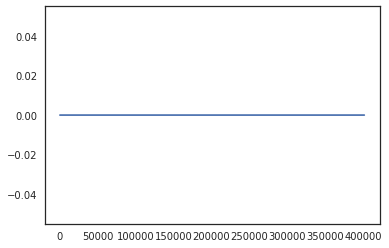

In [267]:
plt.plot(bools)

In [198]:
visible_susp_ops = susp_ops[bools]
invisible_susp_ops = susp_ops[~bools]

In [202]:
invisible_susp_ops.P_SENDTOKFMBOOL.value_counts()

7    34
0    22
2     1
Name: P_SENDTOKFMBOOL, dtype: int64

In [203]:
visible_susp_ops.P_SENDTOKFMBOOL.value_counts()

2    368802
8     26846
7      5850
5         1
1         1
Name: P_SENDTOKFMBOOL, dtype: int64

In [205]:
off_members.P_OPERATIONID.isin(invisible_susp_ops.P_OFFLINEOPERATIONID).any()

False

In [211]:
susp_members.P_SUSPICIOUSOPERATIONID.isin(invisible_susp_ops.ID).sum()

47

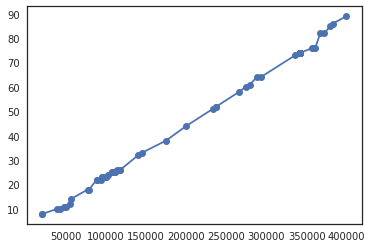

In [218]:
plt.plot((pd.to_datetime(invisible_susp_ops.P_OPERATIONDATETIME) - pd.to_datetime(off_ops.P_OPERATIONDATETIME).min()).dt.days, marker='o')

In [219]:
invisible_susp_members = susp_members[susp_members.P_SUSPICIOUSOPERATIONID.isin(invisible_susp_ops.ID)]

In [223]:
invisible_susp_members.groupby('P_SUSPICIOUSOPERATIONID').size()

P_SUSPICIOUSOPERATIONID
531992871    1
532504845    1
532517773    2
535264326    1
535271233    1
536555968    2
536557490    2
537080201    1
538006071    1
538006851    1
538008330    1
538008632    2
538419104    1
538420193    1
538421153    1
538445005    1
540949224    2
543572069    1
549332958    2
549743665    2
549765316    2
552177677    2
553240743    1
559405978    1
559576399    1
559612934    2
560808000    1
561891711    2
561978018    2
563902998    1
566285263    1
567247652    2
568331538    1
591037081    1
dtype: int64

In [224]:
off_members.columns

Index(['ID', 'P_OPERATIONID', 'P_CLIENTID', 'P_BSCLIENTID', 'P_BANK_CLIENT',
       'P_REGOPENDATE', 'P_COUNTRYCODE', 'P_CLIENT_TYPE', 'P_CLIENTROLE',
       'P_CLIENTKIND', 'P_ACCOUNT', 'P_BSACCOUNT', 'P_BANK',
       'P_BANKCOUNTRYCODE', 'P_BANKNAME', 'P_IPDL', 'P_DATE_INSERT',
       'P_DATE_UPDATE', 'P_USERNAME', 'CHANGEDATE', 'P_SDP', 'P_ORGFORM',
       'P_BANKCITY', 'P_OPER_DATE', 'P_OPERATIONDATE'],
      dtype='object')

In [225]:
susp_members.columns

Index(['ID', 'P_SUSPICIOUSOPERATIONID', 'P_CLIENTID', 'P_BSCLIENTID', 'P_NAME',
       'P_BANK_CLIENT', 'P_REGOPENDATE', 'P_COUNTRYCODE', 'P_CLIENT_TYPE',
       'P_CLIENTROLE', 'P_CLIENTKIND', 'P_ACCOUNT', 'P_BANK',
       'P_BANKCOUNTRYCODE', 'P_BANKNAME', 'P_IPDL', 'P_DATE_INSERT',
       'P_DATE_UPDATE', 'P_USERNAME', 'P_HISTORY', 'CHANGEDATE', 'P_BSACCOUNT',
       'P_LASTNAME', 'P_FIRSTNAME', 'P_MIDDLENAME', 'P_SDP', 'P_ORGFORM',
       'P_CLIENT_CARD_ID', 'P_BANKCITY', 'P_OFFSHORE_CODE', 'P_MEMBERCOMMENTS',
       'CLIENT_CARD_ID', 'CLIENT_CARD_VERSION', 'IS_BANK_OFFSHORE'],
      dtype='object')

In [243]:
((pd.to_datetime(off_members.P_OPER_DATE) - pd.to_datetime(off_members.P_OPERATIONDATE)).dt.days == 0).all()

True

In [233]:
p = pd.to_datetime(off_members.P_OPERATIONDATE)

In [240]:
(p.dt.hour == 0).all()

True

In [250]:
susp_ops.columns

Index(['ID', 'P_ISSUEDBID', 'P_BANKOPERATIONID', 'P_ORDERNUMBER', 'P_BRANCH',
       'P_CURRENCYCODE', 'P_OPERATIONDATETIME', 'P_BASEAMOUNT',
       'P_CURRENCYAMOUNT', 'P_EKNPCODE', 'P_DOCNUMBER', 'P_DOCDATE',
       'P_DOCCATEGORY', 'P_OPERATIONSTATUS', 'P_OPERATIONREASON',
       'P_MESS_NUMBER', 'P_MESS_DATE', 'P_MESS_KIND', 'P_MESS_STATUS',
       'P_SUSPIC_KIND', 'P_SUSPICIOUSTYPECODE', 'P_CRITERIAFIRST',
       'P_CRITERIASECOND', 'P_CRITERIATHIRD', 'P_CRITERIADIFFICULTIES',
       'P_OPERATIONEXTRAINFO', 'P_OFFLINEOPERATIONID', 'P_SENDTOKFMBOOL',
       'P_DATE_INSERT', 'P_DATE_UPDATE', 'P_USERNAME', 'P_OPERATION_LIST',
       'P_COMMENT', 'P_APPROVE', 'P_ATTACHMENT_COMMENT', 'P_HISTORY',
       'CHANGEDATE', 'P_DOCTYPE', 'P_DOCSUSPIC', 'P_PROPERTY',
       'P_PROPERTYNUMBER', 'P_ORIG_OPER_REASON', 'P_DETECTED_BY_FILIAL',
       'P_USER_DETECTED', 'P_COUNTER_MEASURE', 'P_OPERATION_CNT',
       'P_OPERATION_CNT_M'],
      dtype='object')

In [254]:
invisible_susp_members.P_SUSPICIOUSOPERATIONID

1968      553240743
77528     532517773
87388     536555968
87389     537080201
87391     538420193
88573     538008330
89413     538006071
97210     538008632
97212     538006851
103186    538445005
134705    535264326
142673    538419104
143746    538421153
147370    532517773
164246    538008632
170357    535271233
171276    531992871
197732    532504845
228109    536555968
237713    536557490
241806    536557490
254557    540949224
254558    543572069
307384    540949224
463837    552177677
490506    549332958
493139    549743665
522069    549332958
530329    549765316
548996    549765316
612979    552177677
641327    549743665
707973    561891711
708011    567247652
708376    561891711
708377    561978018
711400    566285263
713095    560808000
713963    559405978
716789    568331538
756624    561978018
779455    567247652
839132    559612934
849818    559612934
866275    563902998
894724    559576399
913501    591037081
Name: P_SUSPICIOUSOPERATIONID, dtype: int64

In [255]:
kkk = susp_ops[susp_ops.ID.isin(invisible_susp_members.P_SUSPICIOUSOPERATIONID)]

In [262]:
susp_ops.P_OFFLINEOPERATIONID.isnull().mean()

57

In [258]:
kkk

,ID,P_ISSUEDBID,P_BANKOPERATIONID,P_ORDERNUMBER,P_BRANCH,P_CURRENCYCODE,P_OPERATIONDATETIME,P_BASEAMOUNT,P_CURRENCYAMOUNT,P_EKNPCODE,...,P_DOCTYPE,P_DOCSUSPIC,P_PROPERTY,P_PROPERTYNUMBER,P_ORIG_OPER_REASON,P_DETECTED_BY_FILIAL,P_USER_DETECTED,P_COUNTER_MEASURE,P_OPERATION_CNT,P_OPERATION_CNT_M
38575,531992871,4.0,720920401244,NaN,6,398.0,2017-01-11 11:26:02,3.659931e+06,3659931.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,1
48091,532517773,3.0,160240026170,NaN,3,398.0,2017-01-12 17:51:53,1.050000e+08,105000000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,1
49602,532504845,1.0,720920401244,NaN,6,840.0,2017-01-12 12:55:47,3.990400e+05,1200.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,1.0,NaN,1
55046,537080201,1.0,490805301123,NaN,4,398.0,2017-01-13 00:00:00,5.000000e+03,5000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,1
55756,538006071,4.0,820620300213,NaN,9,398.0,2017-01-15 00:00:00,1.800000e+04,18000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,1
77142,535271233,3.0,040140008392,NaN,6,398.0,2017-01-19 16:07:58,0.000000e+00,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,2,0,4.0,NaN,1
78819,535264326,3.0,141140007060,NaN,15,398.0,2017-01-19 14:15:07,0.000000e+00,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,2,0,NaN,NaN,1
88408,536555968,3.0,160140015746,NaN,6,398.0,2017-01-23 16:10:21,1.500000e+06,1500000.0,341,...,NaN,NaN,NaN,NaN,NaN,2,0,NaN,NaN,1
93361,536557490,3.0,160640023626,NaN,6,398.0,2017-01-23 17:04:45,2.015000e+07,20150000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,1
107400,538008330,5.0,751024300089,NaN,9,398.0,2017-01-26 00:00:00,0.000000e+00,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1,0,1.0,NaN,1


In [248]:
invisible_susp_members.P_SUSPICIOUSOPERATIONID

1968      553240743
77528     532517773
87388     536555968
87389     537080201
87391     538420193
88573     538008330
89413     538006071
97210     538008632
97212     538006851
103186    538445005
134705    535264326
142673    538419104
143746    538421153
147370    532517773
164246    538008632
170357    535271233
171276    531992871
197732    532504845
228109    536555968
237713    536557490
241806    536557490
254557    540949224
254558    543572069
307384    540949224
463837    552177677
490506    549332958
493139    549743665
522069    549332958
530329    549765316
548996    549765316
612979    552177677
641327    549743665
707973    561891711
708011    567247652
708376    561891711
708377    561978018
711400    566285263
713095    560808000
713963    559405978
716789    568331538
756624    561978018
779455    567247652
839132    559612934
849818    559612934
866275    563902998
894724    559576399
913501    591037081
Name: P_SUSPICIOUSOPERATIONID, dtype: int64

In [192]:
off_ops.P_OPERATIONDATETIME.max()

'2017-04-01 00:00:00'

In [143]:
len(susp_frames[0].join(susp_frames[1:], how='outer'))

3517692

In [146]:
keklol = susp_frames[0].join(susp_frames[1:3], how='outer')

In [148]:
keke = keklol.reset_index()

In [154]:
keke[keke.P_SUSPICIOUSOPERATIONID == 529561166]

,P_SUSPICIOUSOPERATIONID,id_from,id_to,id_beneficial
914,529561166,5.034001e+10,9.074102e+10,NaN
915,529561166,5.034001e+10,8.094000e+10,NaN
916,529561166,5.034001e+10,1.206400e+11,NaN
917,529561166,5.034001e+10,1.411400e+11,NaN
918,529561166,5.034001e+10,2.074000e+10,NaN
919,529561166,4.044100e+10,9.074102e+10,NaN
920,529561166,4.044100e+10,8.094000e+10,NaN
921,529561166,4.044100e+10,1.206400e+11,NaN
922,529561166,4.044100e+10,1.411400e+11,NaN
923,529561166,4.044100e+10,2.074000e+10,NaN


In [152]:
pek = keke.groupby('P_SUSPICIOUSOPERATIONID').size()

In [153]:
pek[pek > 1]

P_SUSPICIOUSOPERATIONID
528774965     2
529560060     3
529561122     2
529561166    10
529561197     6
529561371     3
529562109     4
529562646    10
529562736     4
529563010     6
529563141    24
529563203     3
529564720     3
529570382     2
529570412     2
529570418     3
529570657     2
529571450     2
529955992     2
529956228     2
529956459     2
529957181     3
529957230     7
529957590     3
529957617     4
529957690     3
529957764     3
529958618     3
529958830     3
529958955     2
             ..
569129095     2
569129500     2
569129778     2
569129908     2
569129975     2
569130057     2
569130157     2
569130329     2
569130591     2
569130813     2
569130999     4
569131092     2
569131169     2
569131379     2
569131735     6
569132059     3
569132531     2
569132866     2
569132933     2
569133090     5
569133177     3
569133386     2
569133425     2
569133487     2
569133683     2
569133870     2
569157542     2
569157847     3
569157918     3
569158396     4


In [93]:
joined_susp_ops.head(5)

,ID,P_ISSUEDBID,P_BANKOPERATIONID,P_ORDERNUMBER,P_BRANCH,P_CURRENCYCODE,P_OPERATIONDATETIME,P_BASEAMOUNT,P_CURRENCYAMOUNT,P_EKNPCODE,...,P_USER_DETECTED,P_COUNTER_MEASURE,P_OPERATION_CNT,P_OPERATION_CNT_M,id_from,id_to,id_beneficial,id_susp_3,id_susp_6,id_susp_4
0,528661317,1.0,017820170101151123000010129703,NaN,6,840.0,2017-01-01 15:11:00,11791446.40,35380.00,324,...,0,NaN,NaN,1,8.108234e+11,NaN,NaN,NaN,NaN,NaN
1,528661905,1.0,018020170101234837000010266703,NaN,6,840.0,2017-01-01 23:48:00,33328.00,100.00,223,...,0,NaN,NaN,1,8.208143e+11,NaN,NaN,NaN,NaN,NaN
2,528661928,1.0,018020170101195029000010073203,NaN,6,398.0,2017-01-01 19:50:00,5300.00,5300.00,314,...,0,NaN,NaN,1,NaN,8.208143e+11,NaN,NaN,NaN,NaN
3,528661938,1.0,011120170101181325000010222500,NaN,10,398.0,2017-01-01 18:13:00,275.47,275.47,324,...,0,NaN,NaN,1,9.104203e+11,NaN,NaN,NaN,NaN,NaN
4,528661953,1.0,018020170101155728000020070403,NaN,6,840.0,2017-01-01 15:57:00,33328.00,100.00,223,...,0,NaN,NaN,1,8.208143e+11,NaN,NaN,NaN,NaN,NaN


In [126]:
susp_frames[0]

,id_from
P_SUSPICIOUSOPERATIONID,
529947853,60141003453
529947866,1240000643
529947875,781112450075
529947883,970740000134
529947893,510417400852
529950038,50841007822
529950048,50241002552
529950057,41241001783
529950068,50841007822


In [128]:
keks = susp_members[susp_members.P_CLIENTROLE == 1]

In [134]:
len(keks.P_SUSPICIOUSOPERATIONID.unique())

367397

In [121]:
for susp_frame in susp_frames:
    print(len(susp_frame))

506823
406390
334
10
1
5


In [120]:
for susp_frame in susp_frames:
    display(susp_frame.head(5))

,id_from
P_SUSPICIOUSOPERATIONID,
529947853,60141003453
529947866,1240000643
529947875,781112450075
529947883,970740000134
529947893,510417400852


,id_to
P_SUSPICIOUSOPERATIONID,
529947853,60141003453
529947866,1240000643
529947883,970740000134
529950027,50241002552
529950038,50540006352


,id_beneficial
P_SUSPICIOUSOPERATIONID,
530074356,681006300223
529571258,970430401658
529570418,970430401658
530136326,681006300223
530529969,640410400038


,id_susp_3
P_SUSPICIOUSOPERATIONID,
537057831,820722303080
534368799,710815399078
540342800,820722303080
545230799,740123402134
552619776,820722303080


,id_susp_6
P_SUSPICIOUSOPERATIONID,
538419104,30640000918


,id_susp_4
P_SUSPICIOUSOPERATIONID,
553824779,761102302209
553333375,761102302209
549332958,761102302209
552177677,770828402638
559150652,710815399078


In [113]:
sops = susp_ops.set_index('ID', drop=False)

In [115]:
susp_res

,id_from,id_to,id_beneficial,id_susp_3,id_susp_6,id_susp_4
P_SUSPICIOUSOPERATIONID,,,,,,
528661317,8.108234e+11,NaN,NaN,NaN,NaN,NaN
528661905,8.208143e+11,NaN,NaN,NaN,NaN,NaN
528661928,NaN,8.208143e+11,NaN,NaN,NaN,NaN
528661938,9.104203e+11,NaN,NaN,NaN,NaN,NaN
528661953,8.208143e+11,NaN,NaN,NaN,NaN,NaN
528661959,NaN,8.502224e+11,NaN,NaN,NaN,NaN
528661979,NaN,9.306094e+11,NaN,NaN,NaN,NaN
528661985,8.701013e+11,NaN,NaN,NaN,NaN,NaN
528661993,8.512293e+11,NaN,NaN,NaN,NaN,NaN


In [116]:
susp_res

,id_from,id_to,id_beneficial,id_susp_3,id_susp_6,id_susp_4
P_SUSPICIOUSOPERATIONID,,,,,,
528661317,8.108234e+11,NaN,NaN,NaN,NaN,NaN
528661905,8.208143e+11,NaN,NaN,NaN,NaN,NaN
528661928,NaN,8.208143e+11,NaN,NaN,NaN,NaN
528661938,9.104203e+11,NaN,NaN,NaN,NaN,NaN
528661953,8.208143e+11,NaN,NaN,NaN,NaN,NaN
528661959,NaN,8.502224e+11,NaN,NaN,NaN,NaN
528661979,NaN,9.306094e+11,NaN,NaN,NaN,NaN
528661985,8.701013e+11,NaN,NaN,NaN,NaN,NaN
528661993,8.512293e+11,NaN,NaN,NaN,NaN,NaN


In [97]:
len(joined_offline_ops)

8216597

In [100]:
len(joined_susp_ops.ID.unique())

401346

In [103]:
len(joined_offline_ops.ID.unique())

8216585

In [104]:
len(susp_ops.ID.unique())

401557

In [107]:
spo_sizes = susp_ops.groupby('ID').size()

In [110]:
len(susp_ops)

401557

In [111]:
len(joined_offline_ops)

8216597

In [83]:
offline_op_columns = [
    'ID',
    'P_ISSUEDBID',
    'P_BRANCH',
    'P_CURRENCYCODE',
    'P_OPERATIONDATETIME',
    'P_BASEAMOUNT',
    'P_EKNPCODE',
    'P_DOCNUMBER',
    'P_DOCDATE',
    'P_DOCCATEGORY',
    #'P_OPERATIONSTATUS',
    'P_OPERATIONREASON',
    #'P_CHECKED',
    'P_TOEXTRACTBOOL',
    #'P_DOCTYPE',
    #'P_DOCSUSPIC',
    #'P_PROPERTY',
    #'P_PROPERTYNUMBER',
    'P_KFM_OPER_REASON',
    'P_BS_OPER_TYPE',
    'P_ORIG_OPER_NUMBER',
    'P_WAS_SEND',
    #'P_SDP',
    #'RISK_CHECKED',
    #'P_INNER_SUSP_CHECK',
]

offline_members_columns = [
    'ID',
    'P_OPERATIONID',
    'P_CLIENTID',
    'P_BSCLIENTID',
    'P_BANK_CLIENT',
    'P_REGOPENDATE',
    'P_COUNTRYCODE',
    'P_CLIENT_TYPE',
    'P_CLIENTROLE',
    'P_CLIENTKIND',
    'P_ACCOUNT',
    'P_BSACCOUNT',
    'P_BANK',
    'P_BANKCOUNTRYCODE',
    'P_BANKNAME',
    'P_IPDL',
    'P_DATE_INSERT',
    'P_DATE_UPDATE',
    'P_USERNAME',
    'CHANGEDATE',
    'P_SDP',
    'P_ORGFORM',
    'P_BANKCITY',
    'P_OPER_DATE',
    'P_OPERATIONDATE'
]

join suspicious operations with flattened members info took 2.864s


In [170]:
n = 100000
kekes = np.random.randn(n, 2) * 10

/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


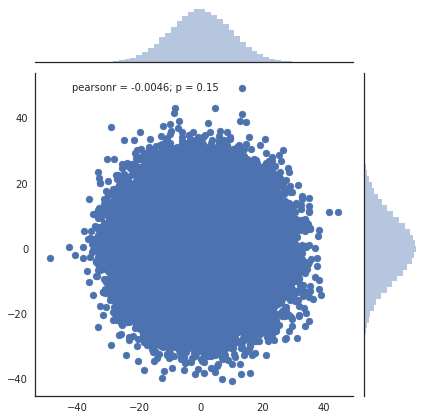

In [172]:
sns.jointplot(*kekes.T)

In [173]:
nr_cubes, overlap_perc = 10, 0.25

In [176]:
import kmapper as km

In [185]:
class BalancedCover(km.Cover):
    def __init__(self, nr_cubes=10, overlap_perc=0.2):
        self.nr_cubes = nr_cubes
        self.overlap_perc = overlap_perc
    
    def define_bins(self, data):
        indexless_data = data[:, 1:]
        bounds = (np.min(indexless_data, axis=0),
                  np.max(indexless_data, axis=0))

        self.di = np.arange(1, data.shape[1])
        self.nr_dimensions = len(self.di)
        
        if np.isscalar(self.nr_cubes):
            self.nr_cubes = np.repeat([int(self.nr_cubes)], self.nr_dimensions)
        if np.isscalar(self.overlap_perc):
            self.overlap_perc = np.repeat([self.overlap_perc], self.nr_dimensions)
        self.nr_cubes = np.array(self.nr_cubes, dtype=int)
        self.overlap_perc = np.array(self.overlap_perc, dtype=float)

        self.window_perc_widths = 100.0 / (self.nr_cubes * (1.0 - self.overlap_perc) + self.overlap_perc)
        self.window_perc_steps = self.window_perc_widths * (1.0 - self.overlap_perc)
        
        self.overlapping_percentiles = []
        for d, (window_perc_width, window_perc_step) in enumerate(zip(self.window_perc_widths, self.window_perc_steps)):
            self.overlapping_percentiles.append(np.stack([
                np.linspace(0.0, window_perc_step * (nr_cubes - 1), num=self.nr_cubes[d], endpoint=True),
                np.linspace(window_perc_width, 100.0, num=self.nr_cubes[d], endpoint=True)
            ], axis=1))
        assert len(self.nr_cubes) == self.nr_dimensions, "There are {} ({}) dimensions specified but {} dimensions needing specification. If you supply specific number of cubes for each dimension, please supply the correct number.".format(
            len(self.nr_cubes), self.nr_cubes, self.nr_dimensions)
        assert len(self.overlap_perc) == self.nr_dimensions, "There are {} ({}) dimensions specified but {} dimensions needing specification. If you supply specific number of cubes for each dimension, please supply the correct number.".format(
            len(self.overlap_perc), self.overlap_perc, self.nr_dimensions)
        
        #print('overlapping percentiles:')
        #print(self.overlapping_percentiles)
        
        cubes = self.nr_cubes
        
        return map(np.asarray, np.ndindex(*cubes))

    def find_entries(self, data, cube, verbose=0):
        """Find all entries in data that are in the given cube.

        Parameters
        ----------
        data: Numpy array
            Either projected data or original data.
        cube:
            an item from the list of cubes provided by `cover.define_bins` iterable.

        Returns
        -------
        hypercube: Numpy Array
            All entries in data that are in cube.

        """
        #if data.shape[1] != 2:
        #    raise ValueError('indexless data must have 1 dimension')
        indexless_data = data[:, 1:]
        bounds = []
        for d in range(self.nr_dimensions):
            i = cube[d]
            cube_perc_bounds = self.overlapping_percentiles[d][i]
            #print(cube_perc_bounds)
            bounds.append([np.percentile(indexless_data[:, d], cube_perc_bounds[0]),
                           np.percentile(indexless_data[:, d], cube_perc_bounds[1])])
        bounds = np.array(bounds)
        #print(bounds)
        
        # Slice the hypercube
        entries = np.all((data[:, self.di] >= bounds[:, 0]) & (data[:, self.di] < bounds[:, 1]), axis=1)

        hypercube = data[entries]

        return hypercube

In [201]:
bc = BalancedCover(nr_cubes=[10, 10], overlap_perc=[0.25, 0.4])

In [202]:
#ikekes = np.c_[np.arange(n), kekes]

In [203]:
entries = [bc.find_entries(ikekes, cube) for cube in bc.define_bins(ikekes)]

overlapping percentiles:
[array([[  0.        ,  12.90322581],
       [  9.67741935,  22.58064516],
       [ 19.35483871,  32.25806452],
       [ 29.03225806,  41.93548387],
       [ 38.70967742,  51.61290323],
       [ 48.38709677,  61.29032258],
       [ 58.06451613,  70.96774194],
       [ 67.74193548,  80.64516129],
       [ 77.41935484,  90.32258065],
       [ 87.09677419, 100.        ]]), array([[  0.   ,  15.625],
       [  9.375,  25.   ],
       [ 18.75 ,  34.375],
       [ 28.125,  43.75 ],
       [ 37.5  ,  53.125],
       [ 46.875,  62.5  ],
       [ 56.25 ,  71.875],
       [ 65.625,  81.25 ],
       [ 75.   ,  90.625],
       [ 84.375, 100.   ]])]


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


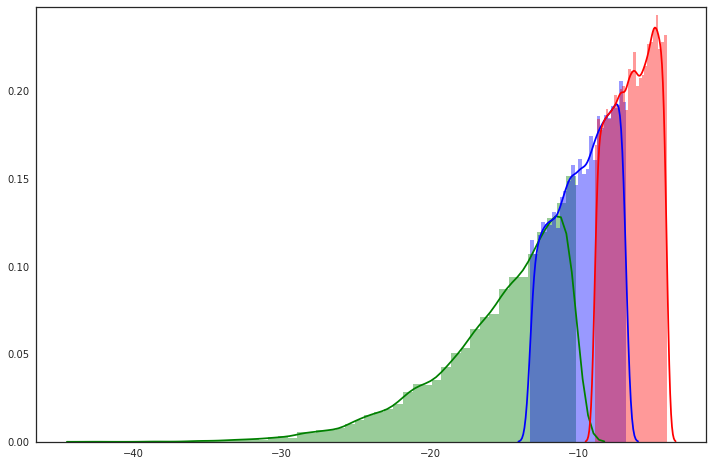

In [169]:
sns.distplot(entries[0][:, 1], color='g')
sns.distplot(entries[1][:, 1], color='b')
sns.distplot(entries[2][:, 1], color='r')

In [168]:
[len(el) for el in entries]

[15625, 15625, 15625, 15625, 15625, 15625, 15625, 15625, 15625, 15624]

In [111]:
class TimeWindowCover(km.Cover):
    def __init__(self, window_length=10, window_overlap=3, nr_cubes=10, overlap_perc=0.2):
        window_length = int(window_length)
        if window_length < 2:
            print('window_length must be greater than 1')
        if isinstance(window_overlap, float):
            if not 0 < window_overlap < 1:
                raise ValueError('window_overlap must be > 0 and < 1')
            else:
                window_overlap = max(1, int(window_overlap))
        if isinstance(window_overlap, int):
            if window_overlap >= window_length:
                raise ValueError('window_overlap must be less that window_length')
            else:
                self.nr_cubes = nr_cubes
                self.overlap_perc = overlap_perc
                self.window_length = window_length
                self.window_overlap = window_overlap
                #self.nr_cubes = len(list(self.define_bins(data=None)))
                #self.overlap_perc = self.window_overlap / self.window_length
    
    def define_bins(self, data):
        """Returns an iterable of all bins in the cover.
        """
        indexless_data = data[:, 2:]
        bounds = (np.min(indexless_data, axis=0),
                  np.max(indexless_data, axis=0))

        # We chop up the min-max column ranges into 'nr_cubes' parts
        self.chunk_dist = (bounds[1] - bounds[0]) / self.nr_cubes

        # We calculate the overlapping windows distance
        self.overlap_dist = self.overlap_perc * self.chunk_dist

        # We find our starting point
        self.d = bounds[0]

        # Use a dimension index array on the projected X
        # (For now this uses the entire dimensionality, but we keep for experimentation)
        self.di = np.array(range(2, data.shape[1]))
        self.nr_dimensions = len(self.di)

        if type(self.nr_cubes) is not list:
            cubes = [self.nr_cubes] * self.nr_dimensions
        else:
            assert len(self.nr_cubes) == self.nr_dimensions, "There are {} ({}) dimensions specified but {} dimensions needing specification. If you supply specific number of cubes for each dimension, please supply the correct number.".format(
                len(self.nr_cubes), self.nr_cubes, self.nr_dimensions)
            cubes = self.nr_cubes
        
        n = int(data[:, 1].max()) - int(data[:, 1].min())
        n_time_cubes = (n // (self.window_length - self.window_overlap) + (1 if n % (self.window_length - self.window_overlap) != 0 else 0))
        #print(n_time_cubes)
        #print(cubes)
        #if data.shape[1] != 2:
        #    raise ValueError('indexless data must have 1 dimension')
        #n = len(data[:, 1])
        #n = len(np.unique(self.df.time))
        #return range(n // (self.window_length - self.window_overlap) + (1 if n % (self.window_length - self.window_overlap) != 0 else 0))
        return map(np.asarray, np.ndindex(n_time_cubes, *cubes))

    
    def find_entries(self, data, cube, verbose=0):
        """Find all entries in data that are in the given cube.

        Parameters
        ----------
        data: Numpy array
            Either projected data or original data.
        cube:
            an item from the list of cubes provided by `cover.define_bins` iterable.

        Returns
        -------
        hypercube: Numpy Array
            All entries in data that are in cube.

        """
        #if data.shape[1] != 2:
        #    raise ValueError('indexless data must have 1 dimension')
        indexless_time = pd.Series(data[:, 1].astype(int))
        indexless_data = data[:, 2:]
        n = int(indexless_time.max()) - int(indexless_time.min())
        time_cube, cube = cube[0], cube[1:]

        start = (self.window_length - self.window_overlap) * time_cube
        time_range = np.arange(start, min(n, start + self.window_length), 1)
        is_time_entry = indexless_time.isin(time_range).values


    
        chunk = self.chunk_dist
        overlap = self.overlap_dist
        lower_bound = self.d + (cube * chunk)
        upper_bound = lower_bound + chunk + overlap

        #print('lower_bound: {}, upper_bound: {}'.format(lower_bound, upper_bound))
        # Slice the hypercube
        entries = np.all((data[:, self.di] >= lower_bound) & (data[:, self.di] < upper_bound), axis=1)
        #print(is_time_entry)
        #print(entries)

        hypercube = data[is_time_entry & entries]
        #hypercube = data[np.logical_and(is_time_entry, np.invert(np.any(entries == False, axis=1)))]

        return hypercube

array([ 0.   ,  9.375, 18.75 , 28.125, 37.5  , 46.875, 56.25 , 65.625,
       75.   , 84.375])